In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math
from OIP21_lib_ImageProcessing_V6 import *
from scipy import ndimage
from skimage.feature import peak_local_max
plt.rcParams['figure.figsize'] = [12, 10]
#%matplotlib notebook

In [2]:
def mean_class_variance(hist, thresh):
    wf = 0.0
    uf = 0.0
    ub = 0.0
    wb = 0.0
    total = np.sum(hist)
    # print(total)
    if len(hist) > 256:
        raise IndexError("object too large, recheck input")
    for i in range(len(hist)):
        if i < thresh:
            wb += hist[i]
            ub = ub + (i * hist[i])
        elif i >= thresh:
            wf += hist[i]
            uf = uf + (i * hist[i])
    if wb==0:
        ub=0
    else:
        ub = ub / wb
    if wf == 0:
        uf=0
    else:
        uf = uf / wf
    wb = wb / total
    wf = wf / total




    #print(thresh,wb,wf,uf,ub,total)
    variance = float(wb * wf * ((ub - uf) ** 2))
    return (variance, thresh)

def auto_thresh(img, mode="Thresholding"):
    hst = hist256(img)
    variance_list = []
    for thresh in range(len(hst)):
        if thresh > 1:
            variance_list.append(mean_class_variance(hst, thresh))
    # print(variance_list)
    # print("MAX tuple: ", max(variance_list))
    var, thresh = max(variance_list)
    #print("MAX tuple: ", thresh)
    if mode == "Thresholding":
        return threshold(img, thresh)
    elif mode == "UpperSave":
        img[img <= thresh] = 0
        return img
    elif mode == "LowerSave":
        img[img >= thresh] = 255
        return img

In [3]:
def FloodFillLabeling_modified(imgBIN):

    label = 2
    # collect the non-zero / foreground elements: 
    nzi = np.nonzero(imgBIN)
    # make copy: 
    IMG = deepcopy(imgBIN)

    zones = []
    # Flood fill loop: 
    #for cnt, u in enumerate(FGu):
    for i in np.transpose(nzi):
        IMG , zone = FloodFill_BF_modified(IMG, i[0] , i[1], label)
        if (not zone[0]==0) and (not zone[1]==IMG.shape[0]) and (not zone[2]==0) and (not zone[3]==IMG.shape[1]):
            zones.append(zone)
            label = label + 1
    return IMG ,zones

#insert image, (u,v) (start pixel), label nr
def FloodFill_BF_modified(IMG, u, v, label):
    '''
    Breadth-First Version (we treat lists as queues)
    '''
    xmax=0
    xmin=IMG.shape[0]
    ymax=0
    ymin=IMG.shape[1]
    S = []
    S.append([u,v])
    while S:  # While S is not empty...
        xy = S[0]
        x = xy[0]
        y = xy[1]
        S.pop(0)
        if x <= IMG.shape[0] and y <= IMG.shape[1] and  IMG[x,y] == 1:
            if xmax<x:
                xmax=x
            elif xmin>x:
                xmin=x
            if ymax<y:
                ymax=y
            elif ymin>y:
                ymin=y
            IMG[x,y] = label
            if x+1<IMG.shape[0]:
                S.append([x+1, y])
            if y+1<IMG.shape[1]:
                S.append([x, y+1])
            if y-1>=0:
                S.append([x,y-1])
            if x-1>=0:
                S.append([x-1,y])
    return IMG , [xmax,xmin,ymax,ymin]


Text(0.5, 1.0, 'Region label OIP')

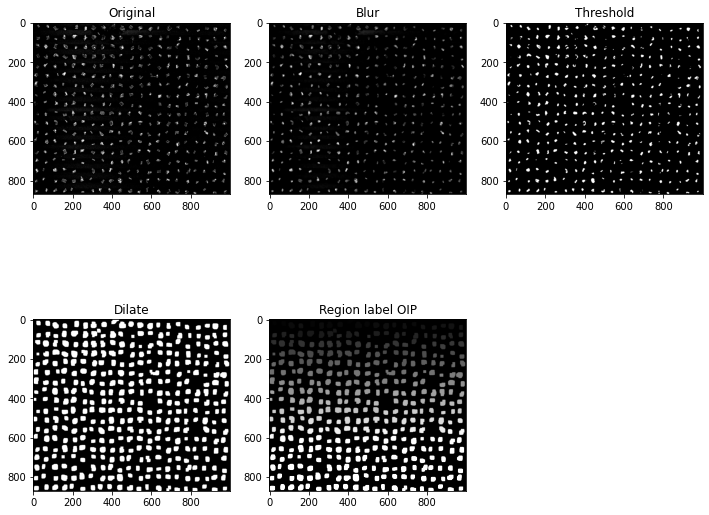

In [4]:
Number = 2
# Start loading in the 3 image types, 
# The first type is a Circle cluster image
# The second type is a Line/Rod cluster image
# The third type is a triangle cluster image
if Number == 1:
    img = cv2.imread('001_002.tif', cv2.IMREAD_GRAYSCALE)
elif Number == 2:
    img = cv2.imread('R001_001.tif', cv2.IMREAD_GRAYSCALE)
elif Number == 3:
    img = cv2.imread('T001.png', cv2.IMREAD_GRAYSCALE)

# Then we cut the gunk that is not needed from the image, this would be un-needed data
# or things that should not be in the image like half-clusters and other things that would
# screw with the data.

if Number == 1:
    img = img[0:870,:]
    img_org = img
elif Number == 2: 
    img = img[0:870,0:1000]
    #img = img[52:244,382:664]
    #img = img[0:870,0:679]
    #img = img[100:870,0:750]
    img_org = img
elif Number == 3:
    img[755:844,672:845] = 0
    img_org = img

#prepare for region labeling    
img = cv2.medianBlur(img, 7)
ret,thresh = cv2.threshold(img,50,255,cv2.THRESH_BINARY)
kernel = np.ones((7,7), np.uint8)
threshDil = cv2.dilate(thresh, kernel, iterations=2)

#255 to 1 since floodfill is expecting that
threshDilBin = threshDil.copy()
threshDilBin[threshDilBin == 255] = 1
threshDilBin = threshDilBin.astype('uint16')

labelsOIP , zones = FloodFillLabeling_modified(threshDilBin)

plt.subplot(2,3,1)
plt.imshow(img_org,'gray',vmin=0,vmax=255)
plt.title("Original")
plt.subplot(2,3,2)
plt.imshow(img,'gray',vmin=0,vmax=255)
plt.title("Blur")
plt.subplot(2,3,3)
plt.imshow(thresh,'gray',vmin=0,vmax=255)
plt.title("Threshold")
plt.subplot(2,3,4)
plt.imshow(threshDil,'gray',vmin=0,vmax=255)
plt.title("Dilate")
plt.subplot(2,3,5)
plt.imshow(labelsOIP,'gray',vmin=0,vmax=255)
plt.title("Region label OIP")

In [5]:
height, width = np.shape(img_org)
clusterArray=[]

for i in zones:
    y2=i[0]
    y1=i[1]
    x2=i[2]
    x1=i[3]
    if(x1>0 and y1>0 and x2<width-1 and y2<height-1):
        clusterArray.append(img_org[y1:y2,x1:x2])


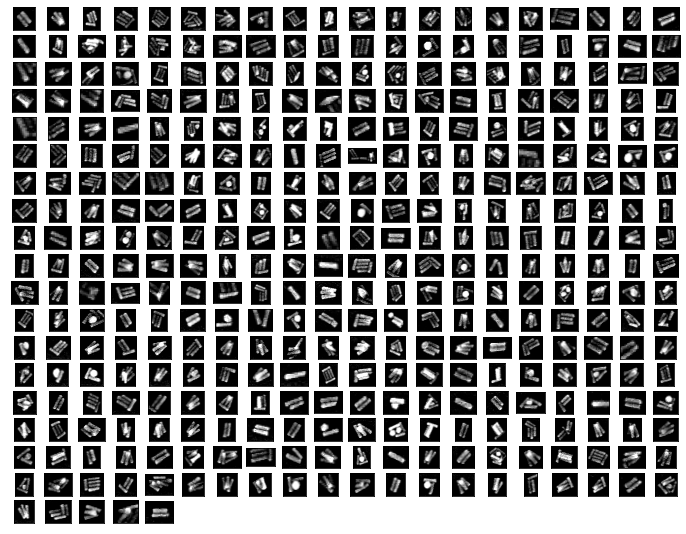

In [6]:
size = math.ceil(math.sqrt(len(clusterArray)))
count = 1

for i in clusterArray:
    plt.subplot(size,size,count)
    plt.imshow(i,'gray',vmin=0,vmax=255)
    plt.xticks([])
    plt.yticks([])
    count+=1

C:\Users\agnib\AppData\Local\Temp/ipykernel_21720/3995419908.py:27: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  localMax = peak_local_max(D, indices=False, min_distance=3,labels=thresh)


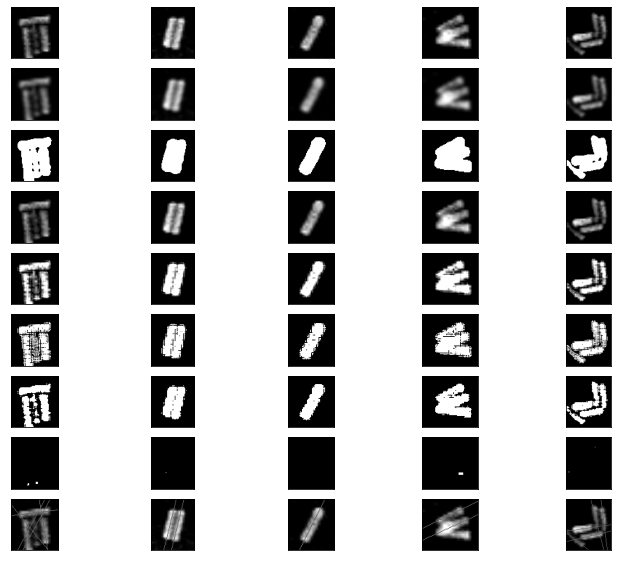

In [7]:
count = 1
#175
start = 175
plotX = 5
plotY = 9
for i in clusterArray[start:start+5]:
    img = i.copy()
    #scale the image so i have more pixels to play with
    scale_percent = 300 # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    img = cv2.resize(img, dim) 
    #blur to make mask to remove everything outside the cluster
    img_blur = cv2.blur(img, (5,5))
    ret,mask = cv2.threshold(img_blur,20,255,cv2.THRESH_BINARY)
    img_noise = cv2.bitwise_and(img,img,mask=mask)

    kernel = np.array([[-1,-1,-1], [-1,10,-1], [-1,-1,-1]])
    img_hat1 = cv2.filter2D(img_noise, -1, kernel)
    img_hat2 = cv2.filter2D(img_hat1, -1, kernel)


    thresh = auto_thresh(img_hat1)
    
    D = ndimage.distance_transform_edt(thresh)
    localMax = peak_local_max(D, indices=False, min_distance=3,labels=thresh)
    localMax = np.multiply(localMax,255).astype('uint8')
    kernel = np.ones((3,3), np.uint8)
    localMax = cv2.dilate(localMax, kernel, iterations=1)
    
    drawLines = []
    lines = cv2.HoughLines(localMax,1,(1*np.pi)/180,8)
    
    while lines is not None :
        drawLines.append([lines[0][0][0],lines[0][0][1]])
        a = math.cos(lines[0][0][1])
        b = math.sin(lines[0][0][1])
        x0 = a * lines[0][0][0]
        y0 = b * lines[0][0][0]
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        cv2.line(localMax, pt1, pt2, (0,0,0), 3)
        lines = cv2.HoughLines(localMax,1,(1*np.pi)/180,8)
        
    img_lines = img.copy()
    
    for i in drawLines:
        a = math.cos(i[1])
        b = math.sin(i[1])
        x0 = a * i[0]
        y0 = b * i[0]
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        cv2.line(img_lines, pt1, pt2, (100,0,0), 1)
    
    plt.subplot(plotY,plotX,count)
    plt.imshow(img,'gray',vmin=0,vmax=255)
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(plotY,plotX,count+5)
    plt.imshow(img_blur,'gray',vmin=0,vmax=255)
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(plotY,plotX,count+5*2)
    plt.imshow(mask,'gray',vmin=0,vmax=255)
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(plotY,plotX,count+5*3)
    plt.imshow(img_noise,'gray',vmin=0,vmax=255)
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(plotY,plotX,count+5*4)
    plt.imshow(img_hat1,'gray',vmin=0,vmax=255)
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(plotY,plotX,count+5*5)
    plt.imshow(img_hat2,'gray',vmin=0,vmax=255)
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(plotY,plotX,count+5*6)
    plt.imshow(thresh,'gray',vmin=0,vmax=255)
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(plotY,plotX,count+5*7)
    plt.imshow(localMax,'gray',vmin=0,vmax=255)
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(plotY,plotX,count+5*8)
    plt.imshow(img_lines,'gray',vmin=0,vmax=255)
    plt.xticks([])
    plt.yticks([])
    
    count+=1
    

([], [])

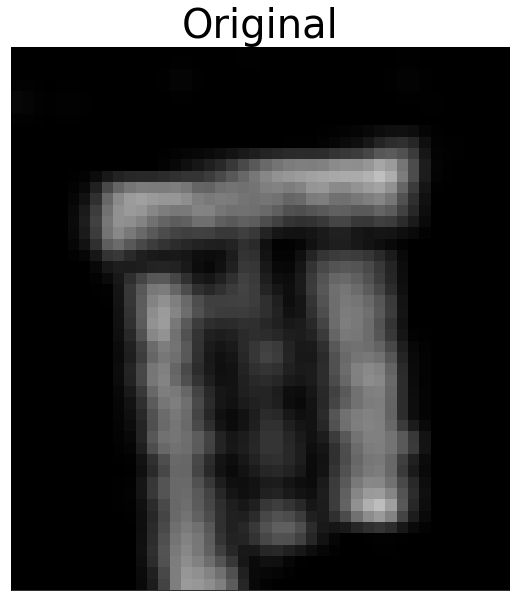

In [8]:
i = clusterArray[175]
img = i.copy()
scale_percent = 200 # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)
img = cv2.resize(img, dim) 
plt.imshow(img,'gray',vmin=0,vmax=255)
plt.title("Original",fontsize=40)
plt.xticks([])
plt.yticks([])

([], [])

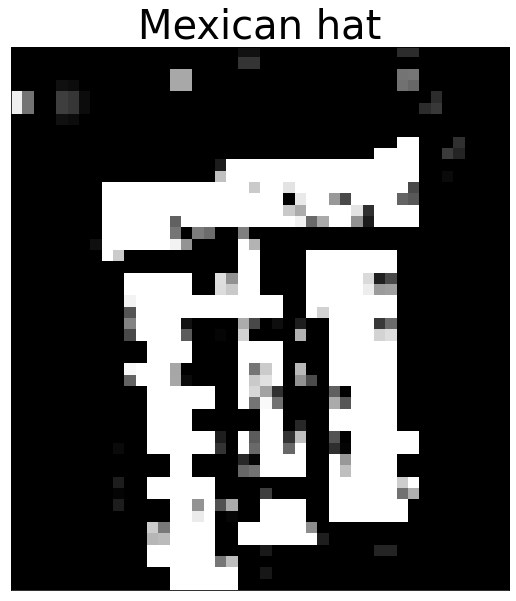

In [9]:
kernel = np.array([[-1,-1,-1], [-1,10,-1], [-1,-1,-1]])
img_hat1 = cv2.filter2D(img, -1, kernel)
img_hat2 = cv2.filter2D(img_hat1, -1, kernel)
plt.imshow(img_hat2,'gray',vmin=0,vmax=255)
plt.title("Mexican hat",fontsize=40)
plt.xticks([])
plt.yticks([])

([], [])

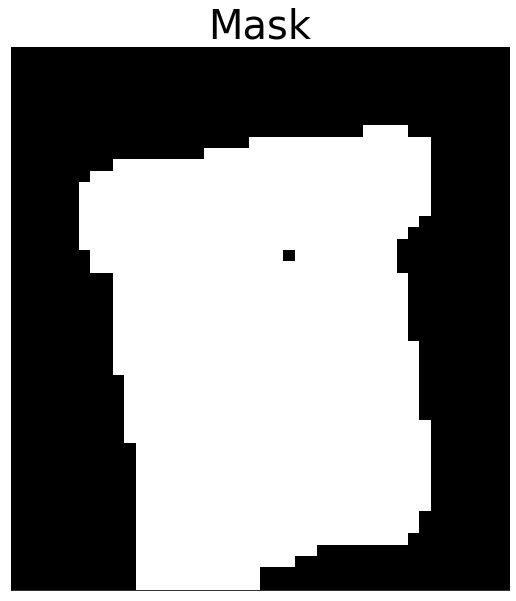

In [10]:
img_blur = cv2.blur(img, (5,5))
ret,mask = cv2.threshold(img_blur,20,255,cv2.THRESH_BINARY)
plt.imshow(mask,'gray',vmin=0,vmax=255)
plt.title("Mask",fontsize=40)
plt.xticks([])
plt.yticks([])

([], [])

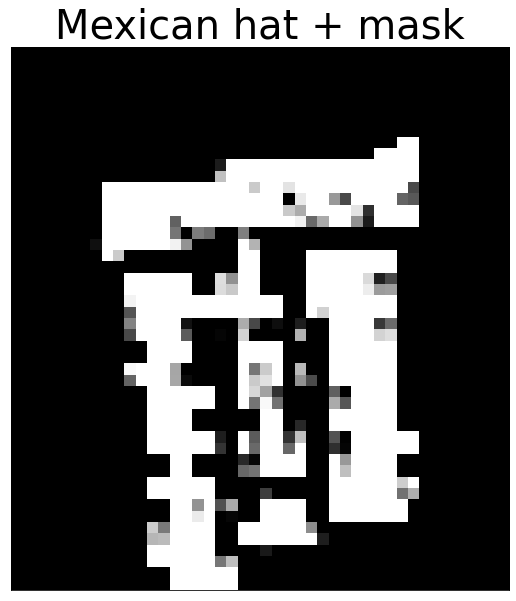

In [11]:
img_noise = cv2.bitwise_and(img_hat2,img_hat2,mask=mask)
plt.imshow(img_noise,'gray',vmin=0,vmax=255)
plt.title("Mexican hat + mask",fontsize=40)
plt.xticks([])
plt.yticks([])

([], [])

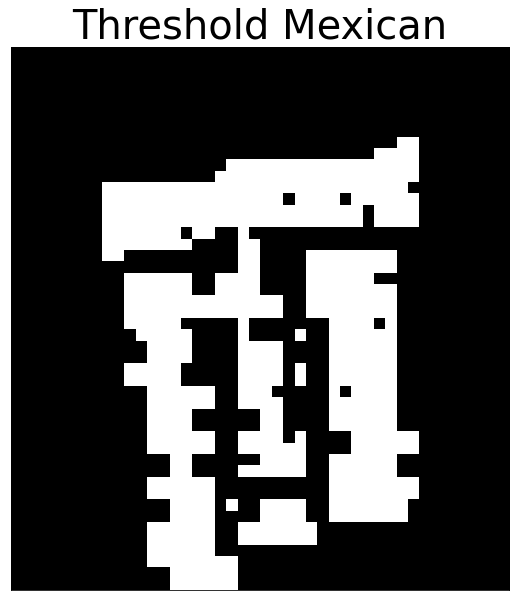

In [12]:
img_thresh_mex = auto_thresh(img_noise)
plt.imshow(img_thresh_mex,'gray',vmin=0,vmax=255)
plt.title("Threshold Mexican",fontsize=40)
plt.xticks([])
plt.yticks([])

([], [])

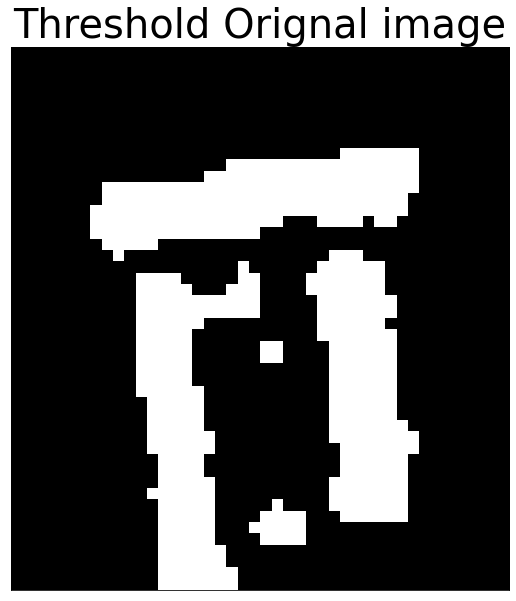

In [13]:
img_thresh = auto_thresh(img)
plt.imshow(img_thresh,'gray',vmin=0,vmax=255)
plt.title("Threshold Orignal image",fontsize=40)
plt.xticks([])
plt.yticks([])

([], [])

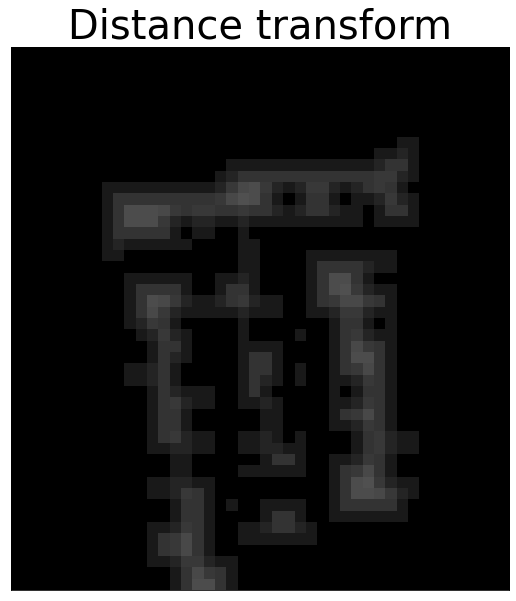

In [14]:
D = ndimage.distance_transform_edt(img_thresh_mex)
plt.imshow(D,'gray',vmin=0,vmax=10)
plt.title("Distance transform",fontsize=40)
plt.xticks([])
plt.yticks([])

C:\Users\agnib\AppData\Local\Temp/ipykernel_21720/4169992922.py:1: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  localMax = peak_local_max(D, indices=False, min_distance=3,labels=img_thresh_mex)


([], [])

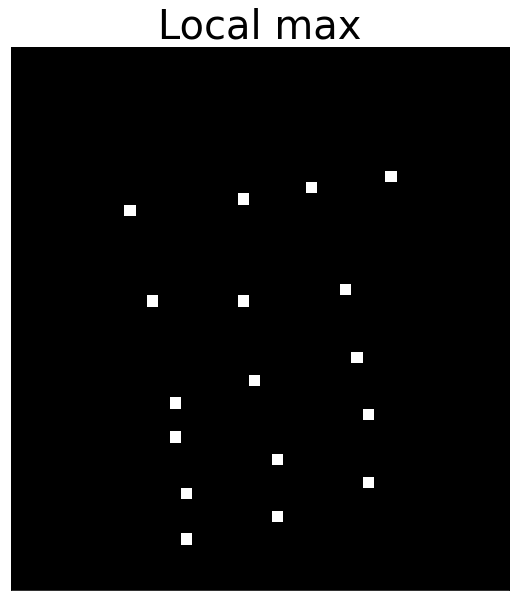

In [15]:
localMax = peak_local_max(D, indices=False, min_distance=3,labels=img_thresh_mex)
localMax = np.multiply(localMax,255).astype('uint8')
plt.imshow(localMax,'gray',vmin=0,vmax=255)
plt.title("Local max",fontsize=40)
plt.xticks([])
plt.yticks([])

([], [])

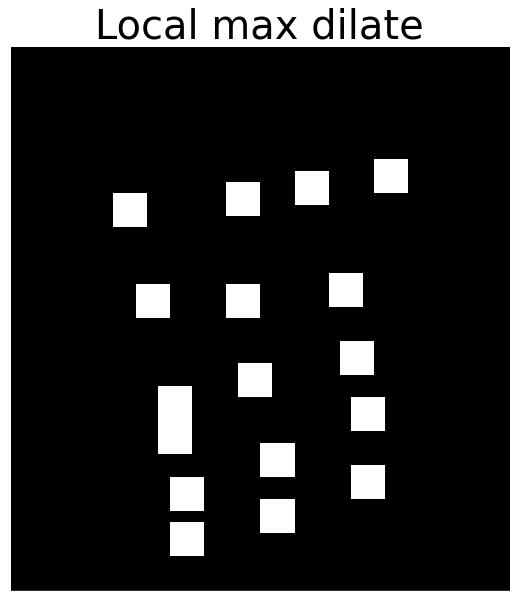

In [16]:
kernel = np.ones((3,3), np.uint8)
localMax_dil = cv2.dilate(localMax, kernel, iterations=1)
plt.imshow(localMax_dil,'gray',vmin=0,vmax=255)
plt.title("Local max dilate",fontsize=40)
plt.xticks([])
plt.yticks([])

([], [])

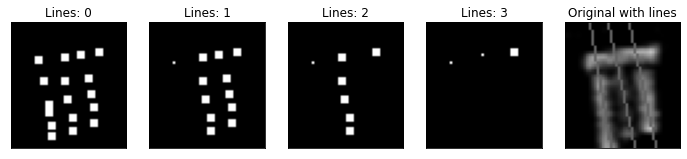

In [17]:
pict_lst = []
count = 0
drawLines = []
lines = cv2.HoughLines(localMax_dil,1,(1*np.pi)/180,8)
pict_lst.append(localMax_dil.copy())
while lines is not None :
    drawLines.append([lines[0][0][0],lines[0][0][1]])
    a = math.cos(lines[0][0][1])
    b = math.sin(lines[0][0][1])
    x0 = a * lines[0][0][0]
    y0 = b * lines[0][0][0]
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    pict_lst.append(pict_lst[count].copy())
    count+=1
    cv2.line(pict_lst[count], pt1, pt2, (0,0,0), 3)
    lines = cv2.HoughLines(pict_lst[count],1,(1*np.pi)/180,8)
    
count =1
for i in pict_lst:
    plt.subplot(1,5,count)
    plt.imshow(i,'gray',vmin=0,vmax=255)
    plt.title("Lines: "+str(count-1))
    plt.xticks([])
    plt.yticks([])
    count+=1

img_lines = img.copy()
    
for i in drawLines:
    a = math.cos(i[1])
    b = math.sin(i[1])
    x0 = a * i[0]
    y0 = b * i[0]
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    cv2.line(img_lines, pt1, pt2, (100,0,0), 1)
plt.subplot(1,5,5)
plt.imshow(img_lines,'gray',vmin=0,vmax=255)
plt.title("Original with lines")
plt.xticks([])
plt.yticks([])